Rozpoczynam analize
Pokolenie 1: Best Fitness = 4.3520742565306136e-14, Worst Fitness = -1.0658141036401503e-14, Avg Fitness = 7.007283642224138e-15
Pokolenie 2: Best Fitness = 4.3520742565306136e-14, Worst Fitness = -1.2434497875801753e-14, Avg Fitness = 9.253708910250679e-15
Pokolenie 3: Best Fitness = 4.218847493575595e-14, Worst Fitness = -1.509903313490213e-14, Avg Fitness = 8.964384790033364e-15
Pokolenie 4: Best Fitness = 4.796163466380676e-14, Worst Fitness = -8.881784197001252e-15, Avg Fitness = 9.987566329527908e-15
Pokolenie 5: Best Fitness = 3.9968028886505635e-14, Worst Fitness = -9.769962616701378e-15, Avg Fitness = 9.28501719954511e-15
Pokolenie 6: Best Fitness = 3.730349362740526e-14, Worst Fitness = -1.2434497875801753e-14, Avg Fitness = 1.0437650743710946e-14
Pokolenie 7: Best Fitness = 4.440892098500626e-14, Worst Fitness = -1.2434497875801753e-14, Avg Fitness = 1.0794920513035322e-14
Pokolenie 8: Best Fitness = 6.306066779870889e-14, Worst Fitness = -1.5987211554602

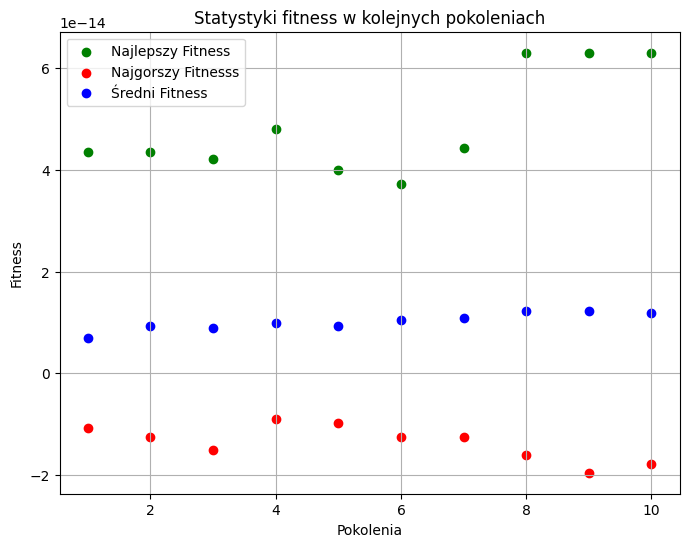

In [ ]:
import chess
import tkinter as tk
from tkinter import Toplevel, filedialog, messagebox
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Ustawienia grafiki
PIECE_IMAGES = {
    "P": "♙",
    "N": "♘",
    "B": "♗",
    "R": "♖",
    "Q": "♕",
    "K": "♔",
    "p": "♟",
    "n": "♞",
    "b": "♝",
    "r": "♜",
    "q": "♛",
    "k": "♚",
}


class ChessApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Szachy z najlepszym ruchem")
        root.resizable(False, False)
        self.board = chess.Board()
        self.is_edit_mode = False
        self.is_remove_mode = False
        self.selected_piece = None
        self.selected_color = None
        self.edit_window = None
        self.create_widgets()

    def create_widgets(self):
        # Plansza szachowa
        self.canvas = tk.Canvas(self.root, width=400, height=400)
        self.canvas.grid(row=0, column=0, columnspan=2, padx=10, pady=10)

        self.draw_board()

        self.root.grid_columnconfigure(0, weight=3)
        self.root.grid_columnconfigure(1, weight=1)

        # Przyciski pod planszą
        self.button_move = tk.Button(
            self.root, text="Znajdź najlepszy ruch", command=self.best_move, width=47
        )
        self.button_move.grid(row=1, column=0, padx=5, pady=10, sticky="n")

        self.button_edit = tk.Button(
            self.root, text="Menu", command=self.toggle_edit_mode, width=5
        )
        self.button_edit.grid(row=1, column=1, padx=5, pady=10, sticky="w")

        # Obsługa kliknięć myszą na planszy
        self.canvas.bind("<Button-1>", self.on_click)

    def draw_board(self):
        self.canvas.delete("all")
        colors = ["#DDB88C", "#A66D4F"]
        size = 50
        for row in range(8):
            for col in range(8):
                x1, y1 = col * size, row * size
                x2, y2 = x1 + size, y1 + size
                color = colors[(row + col) % 2]
                self.canvas.create_rectangle(x1, y1, x2, y2, fill=color, outline="")

        # Rysowanie figur
        for square in chess.SQUARES:
            piece = self.board.piece_at(square)
            if piece:
                row, col = divmod(square, 8)
                x = col * size + size // 2
                y = (7 - row) * size + size // 2
                self.canvas.create_text(
                    x,
                    y,
                    text=PIECE_IMAGES[piece.symbol()],
                    font=("Arial", 24),
                    fill="black",
                    tags=str(square),
                )

    def toggle_edit_mode(self):
        """Włącz / wyłącz tryb edycji."""
        self.is_edit_mode = not self.is_edit_mode
        if self.is_edit_mode:
            self.selected_piece = None
            self.is_remove_mode = False
            self.show_edit_window()
        else:
            self.selected_piece = None
            self.is_remove_mode = False
            if self.edit_window:
                self.edit_window.destroy()

    def show_edit_window(self):
        """Pokazuje okno z dodatkowymi opcjami do dodawania i usuwania figur."""
        self.edit_window = Toplevel(self.root)
        self.edit_window.title("Tryb edycji")
        self.edit_window.resizable(False, False)

        # Ustawienie okna obok głównego
        self.edit_window.geometry(
            f"320x350+{self.root.winfo_x() + self.root.winfo_width() + 10}+{self.root.winfo_y()}"
        )

        # Nagłówek w oknie edycji
        header_label = tk.Label(
            self.edit_window, text="Tryb edycji", font=("Arial", 14, "bold")
        )
        header_label.grid(row=0, column=0, columnspan=3, pady=10, sticky="ew")
        self.edit_window.grid_columnconfigure(0, weight=1)
        self.edit_window.grid_columnconfigure(1, weight=1)

        # Sekcja: Wybór koloru
        color_label = tk.Label(
            self.edit_window, text="Wybierz kolor figury:", font=("Arial", 12)
        )
        color_label.grid(row=1, column=0, columnspan=3, pady=5)

        self.button_white = tk.Button(
            self.edit_window,
            text="Biała",
            command=lambda: self.select_color("white"),
            width=10,
        )
        self.button_white.grid(row=2, column=0, pady=5, padx=10)

        self.button_black = tk.Button(
            self.edit_window,
            text="Czarna",
            command=lambda: self.select_color("black"),
            width=10,
        )
        self.button_black.grid(row=2, column=1, pady=5, padx=10)

        # Sekcja: Dodawanie figur
        piece_label = tk.Label(
            self.edit_window, text="Wybierz figurę:", font=("Arial", 12)
        )
        piece_label.grid(row=3, column=0, columnspan=3, pady=5)

        self.button_add_pawn = tk.Button(
            self.edit_window,
            text="Pionek",
            command=lambda: self.select_piece("P"),
            width=15,
        )
        self.button_add_pawn.grid(row=4, column=0, pady=5)

        self.button_add_knight = tk.Button(
            self.edit_window,
            text="Skoczek",
            command=lambda: self.select_piece("N"),
            width=15,
        )
        self.button_add_knight.grid(row=5, column=0, pady=5)

        self.button_add_bishop = tk.Button(
            self.edit_window,
            text="Goniec",
            command=lambda: self.select_piece("B"),
            width=15,
        )
        self.button_add_bishop.grid(row=4, column=1, pady=5)

        self.button_add_rook = tk.Button(
            self.edit_window,
            text="Wieża",
            command=lambda: self.select_piece("R"),
            width=15,
        )
        self.button_add_rook.grid(row=5, column=1, pady=5)

        self.button_add_queen = tk.Button(
            self.edit_window,
            text="Królowa",
            command=lambda: self.select_piece("Q"),
            width=15,
        )
        self.button_add_queen.grid(row=6, column=0, pady=5)

        self.button_add_king = tk.Button(
            self.edit_window,
            text="Król",
            command=lambda: self.select_piece("K"),
            width=15,
        )
        self.button_add_king.grid(row=6, column=1, pady=5)

        # Sekcja: Usuwanie figur
        self.button_remove_piece = tk.Button(
            self.edit_window,
            text="Usuwanie wyłączone",
            command=self.toggle_remove_mode,
            width=15,
        )
        self.button_remove_piece.grid(row=7, column=0, columnspan=3, pady=10, padx=10)

        # Sekcja: Zapisywanie i wczytywanie pozycji
        self.button_save = tk.Button(
            self.edit_window,
            text="Zapisz pozycję",
            command=self.save_position,
            width=15,
        )
        self.button_save.grid(row=8, column=0, pady=5, padx=10)

        self.button_load = tk.Button(
            self.edit_window,
            text="Wczytaj pozycję",
            command=self.load_position,
            width=15,
        )
        self.button_load.grid(row=8, column=1, pady=5, padx=10)

        # Obsługuje zamknięcie okna edycji
        self.edit_window.protocol("WM_DELETE_WINDOW", self.on_edit_window_close)

    def on_edit_window_close(self):
        """Funkcja, która zostanie wywołana przy zamknięciu okna trybu edycji."""
        self.selected_piece = None
        self.is_remove_mode = False
        self.edit_window.destroy()
        self.is_edit_mode = False

    def toggle_remove_mode(self):
        """Włącz / wyłącz tryb usuwania figury."""
        if self.is_edit_mode:
            self.is_remove_mode = not self.is_remove_mode
            if self.is_remove_mode:
                self.button_remove_piece.config(text="Usuwanie włączone", bg="#ff4747")
            else:
                self.button_remove_piece.config(
                    text="Usuwanie wyłączone", bg="SystemButtonFace"
                )

    def save_position(self):
        """Zapisuje aktualną pozycję szachową do pliku."""
        file_path = filedialog.asksaveasfilename(
            defaultextension=".txt", filetypes=[("Text files", "*.txt")]
        )
        if file_path:
            with open(file_path, "w") as f:
                f.write(self.board.fen())  # Zapisujemy FEN do pliku

    def load_position(self):
        """Wczytuje pozycję z pliku."""
        file_path = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
        if file_path:
            with open(file_path, "r") as f:
                fen = f.read().strip()  # Odczytujemy FEN z pliku
                self.board.set_fen(fen)
            self.draw_board()

    def select_piece(self, piece_type):
        """Wybór figury do dodania."""
        if self.is_edit_mode and self.selected_color:

            self.selected_piece = piece_type

            # Zresetuj tło wszystkich przycisków
            self.reset_highlighting()
            color = "lightblue"

            match piece_type:
                case "P":
                    self.button_add_pawn.config(bg=color)
                case "N":
                    self.button_add_knight.config(bg=color)
                case "B":
                    self.button_add_bishop.config(bg=color)
                case "R":
                    self.button_add_rook.config(bg=color)
                case "Q":
                    self.button_add_queen.config(bg=color)
                case "K":
                    self.button_add_king.config(bg=color)

    def select_color(self, color):
        """Wybór koloru figury."""
        if self.is_edit_mode:
            self.selected_color = color
            self.button_white.config(bg="SystemButtonFace")
            self.button_black.config(bg="SystemButtonFace")

            if color == "white":
                self.button_white.config(bg="lightblue")
            elif color == "black":
                self.button_black.config(bg="lightblue")

    def reset_highlighting(self):
        """Resetuje podświetlenie przycisków figur."""
        self.button_add_pawn.config(bg="SystemButtonFace")
        self.button_add_knight.config(bg="SystemButtonFace")
        self.button_add_bishop.config(bg="SystemButtonFace")
        self.button_add_rook.config(bg="SystemButtonFace")
        self.button_add_queen.config(bg="SystemButtonFace")
        self.button_add_king.config(bg="SystemButtonFace")

    def on_click(self, event):
        """Wykryj kliknięcie na planszy."""
        size = 50
        col = event.x // size
        row = 7 - (event.y // size)
        square = chess.square(col, row)
        if self.is_edit_mode:
            if self.selected_piece and self.selected_color:
                # Dodajemy wybraną figurę na planszy
                piece = chess.Piece.from_symbol(self.selected_piece)
                if self.selected_color == "white":
                    self.board.set_piece_at(square, piece)
                else:
                    piece = chess.Piece.from_symbol(self.selected_piece.lower())
                    self.board.set_piece_at(square, piece)

                self.draw_board()
                self.selected_piece = None

                self.reset_highlighting()

            elif self.is_remove_mode:
                self.board.set_piece_at(square, None)
                self.draw_board()

        else:  # W trybie gry
            self.handle_game_move(square)

    def handle_game_move(self, square):
        """Obsługa ruchu w trybie gry."""
        if not hasattr(self, "selected_square") or self.selected_square is None:
            # Wybieramy figurę do przesunięcia
            piece = self.board.piece_at(square)
            if piece and (
                (piece.color and self.board.turn)
                or (not piece.color and not self.board.turn)
            ):
                self.selected_square = square
                self.highlight_square(square)
                self.highlight_legal_moves(square)
        else:
            # Próba wykonania ruchu
            move = chess.Move(self.selected_square, square)
            piece = self.board.piece_at(self.selected_square)
            if move in self.board.legal_moves:
                self.board.push(move)
                self.draw_board()
            elif (
                piece.piece_type == chess.PAWN
                and piece.color == chess.WHITE
                and square // 8 == 7
            ) or (
                piece.piece_type == chess.PAWN
                and piece.color == chess.BLACK
                and square // 8 == 0
            ):
                self.show_promotion_window(move)
            self.selected_square = None
            self.clear_highlights()

    def show_promotion_window(self, move):
        """Pokazuje okno wyboru promocji, gdy pionek dotrze do ostatniej linii."""

        def on_promotion_choice(choice):
            # Po wyborze promocji, ustawiamy odpowiednią figurę
            promotion_move = chess.Move(
                move.from_square, move.to_square, promotion=choice
            )
            if promotion_move in self.board.legal_moves:
                self.board.push(promotion_move)  # Wykonaj ruch z promocją
                self.draw_board()
            promotion_window.destroy()

        # Tworzymy okno wyboru promocji
        promotion_window = tk.Toplevel()
        promotion_window.title("Wybór promocji")
        promotion_window.resizable(False, False)

        promotion_window.grid_rowconfigure(0, weight=1)
        promotion_window.grid_columnconfigure(0, weight=1)
        promotion_window.grid_columnconfigure(1, weight=1)

        choices = [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT]
        piece_names = {
            chess.QUEEN: "Królowa",
            chess.ROOK: "Wieża",
            chess.BISHOP: "Goniec",
            chess.KNIGHT: "Skoczek",
        }

        for i, choice in enumerate(choices):
            piece_name = piece_names[choice]
            row = i // 2
            col = i % 2
            button = tk.Button(
                promotion_window,
                text=piece_name,
                command=lambda c=choice: on_promotion_choice(c),
                width=15,
            )
            button.grid(row=row, column=col, padx=10, pady=5)

        promotion_window.geometry("255x80")

    def highlight_legal_moves(self, square):
        """Podświetla możliwe ruchy dla wybranej figury."""
        size = 50
        for move in self.board.legal_moves:
            if move.from_square == square:
                row, col = divmod(move.to_square, 8)
                x1, y1 = col * size + size // 3, (7 - row) * size + size // 3
                x2, y2 = x1 + size // 3, y1 + size // 3
                self.canvas.create_oval(x1, y1, x2, y2, fill="blue", tags="highlight")
        self.check_game_status()

    def highlight_square(self, square):
        """Podświetla wybrane pole."""
        size = 50
        row, col = divmod(square, 8)
        x1, y1 = col * size, (7 - row) * size
        x2, y2 = x1 + size, y1 + size
        self.canvas.create_rectangle(
            x1, y1, x2, y2, outline="blue", width=3, tags="highlight"
        )

    def clear_highlights(self):
        """Usuwa wszystkie podświetlenia."""
        self.canvas.delete("highlight")

    def check_game_status(self):
        """Sprawdza, czy gra się zakończyła, i wyświetla odpowiedni komunikat."""
        if self.board.is_checkmate():
            winner = "Czarny" if self.board.turn else "Biały"
            messagebox.showinfo("Koniec gry", f"Szach-mat! Wygrywa {winner}.")
        elif self.board.is_stalemate():
            messagebox.showinfo("Koniec gry", "Gra zakończona patem!")
        elif self.board.is_insufficient_material():
            messagebox.showinfo(
                "Koniec gry", "Gra zakończona - brak materiału do mata."
            )
        elif self.board.is_seventyfive_moves():
            messagebox.showinfo("Koniec gry", "Gra zakończona - zasada 75 ruchów.")
        elif self.board.is_fivefold_repetition():
            messagebox.showinfo(
                "Koniec gry", "Gra zakończona - 5-krotne powtórzenie pozycji."
            )

    # Funkcja do wczytania danych z pliku i utworzenia wykresu punktowego
    def plot_fitness_statistics(self):
        self.wykres = Toplevel(self.root)
        self.wykres.title("Statyskyki fitnessu")
        self.wykres.resizable(False, False)
        self.wykres.geometry(
            f"800x600+{self.root.winfo_x() + self.root.winfo_width() + 10}+{self.root.winfo_y()}"
        )

        filename = "fitness_statistics.txt"

        best_fitness = []
        worst_fitness = []
        avg_fitness = []

        try:
            # Otwieramy plik i czytamy dane
            with open(filename, "r") as file:
                # Pomijamy nagłówek
                next(file)

                # Wczytujemy każdą linię i przetwarzamy dane
                for line in file:
                    # Rozdzielamy wartości w wierszu po spacjach
                    values = line.strip().split()
                    best_fitness.append(float(values[0]))
                    worst_fitness.append(float(values[1]))
                    avg_fitness.append(float(values[2]))

            # Tworzymy wykres punktowy
            generations = range(
                1, len(best_fitness) + 1
            )  # Zakładając, że każda linia to nowe pokolenie

            fig, ax = plt.subplots(figsize=(10, 6))

            ax.scatter(
                generations, best_fitness, label="Najlepszy Fitness", color="green"
            )
            ax.scatter(
                generations, worst_fitness, label="Najgorszy Fitnesss", color="red"
            )
            ax.scatter(generations, avg_fitness, label="Średni Fitness", color="blue")

            # Ustawienia wykresu
            ax.set_title("Statystyki fitness w kolejnych pokoleniach")
            ax.set_xlabel("Pokolenia")
            ax.set_ylabel("Fitness")
            ax.grid(True)
            ax.legend(loc="upper left")

            # Wyświetlenie wykresu w oknie aplikacji
            canvas = FigureCanvasTkAgg(fig, master=self.wykres)
            canvas.draw()
            canvas.get_tk_widget().pack()

        except FileNotFoundError:
            messagebox.showerror(
                "Błąd", "Plik 'fitness_statistics.txt' nie został znaleziony!"
            )
        except Exception as e:
            messagebox.showerror("Błąd", f"Wystąpił błąd: {e}")

    # ===== Funkcja oceny pozycji =====
    def evaluate_position(self, board, piece_values):
        """Ocena pozycji na podstawie materiału."""
        if board.is_checkmate():
            return 1000 if not board.turn else -1000  # Mat to najwyższa ocena
        if board.is_stalemate():
            return 0  # Remis

        score = 0
        for piece in board.piece_map().values():
            value = piece_values[piece.piece_type]
            score += value if piece.color else -value

        return score

    # ===== MiniMax z Alpha-Beta Pruning =====
    def minimax(self, depth, alpha, beta, maximizing_player, piece_values):
        """Implementacja algorytmu MiniMax z Alpha-Beta Pruning."""
        if depth == 0 or self.board.is_game_over():
            return self.evaluate_position(self.board, piece_values)

        legal_moves = list(self.board.legal_moves)

        if maximizing_player:
            max_eval = -float("inf")
            for move in legal_moves:
                self.board.push(move)
                eval = self.minimax(depth - 1, alpha, beta, False, piece_values)
                self.board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float("inf")
            for move in legal_moves:
                self.board.push(move)
                eval = self.minimax(depth - 1, alpha, beta, True, piece_values)
                self.board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    # ===== Funkcja celu dla DEAP =====
    def fitness_material_weights(self, individual):
        """Funkcja celu dla optymalizacji wartości materiałowych."""
        piece_values = {
            chess.PAWN: individual[0],
            chess.KNIGHT: individual[1],
            chess.BISHOP: individual[2],
            chess.ROOK: individual[3],
            chess.QUEEN: individual[4],
            chess.KING: individual[5],
        }

        score = self.minimax(
            depth=3,
            alpha=-float("inf"),
            beta=float("inf"),
            maximizing_player=True,
            piece_values=piece_values,
        )
        return (score,)

    # ===== DEAP Setup =====
    def setup_deap_material_weights(self):
        """Ustawienie DEAP do optymalizacji wag materiałowych."""
        if "FitnessMax" not in creator.__dict__:
            creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        if "Individual" not in creator.__dict__:
            creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_float", random.uniform, 0.5, 10.0)
        toolbox.register(
            "individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=6
        )
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", self.fitness_material_weights)

        return toolbox

    # ===== Funkcja zapisu statystyk do pliku =====
    def save_statistics_to_file(self, filename, best, worst, avg):
        with open(filename, mode="a") as file:
            file.write(f"{best} {worst} {avg}\n")

    # ===== Główna funkcja optymalizacji =====
    def optimize_material_weights(self):
        toolbox = self.setup_deap_material_weights()

        population = toolbox.population(n=250)
        generations = 10

        with open("fitness_statistics.txt", mode="w") as file:
            file.write("Best Fitness Worst Fitness Average Fitness\n")

        # Funkcja zbierająca statystyki fitness
        def gather_fitness_stats(population):
            # Pobieranie fitnessów jednostek
            fitness_values = [ind.fitness.values[0] for ind in population]
            best_fitness = max(fitness_values)
            worst_fitness = min(fitness_values)
            avg_fitness = sum(fitness_values) / len(fitness_values)
            return best_fitness, worst_fitness, avg_fitness

        for gen in range(generations):
            algorithms.eaSimple(
                population,
                toolbox,
                cxpb=0.5,
                mutpb=0.6,
                ngen=1,
                stats=tools.Statistics(lambda ind: ind.fitness.values),
                verbose=False,
            )

            # Zbieranie statystyk
            best_fitness, worst_fitness, avg_fitness = gather_fitness_stats(population)

            # Zapis statystyk do pliku
            self.save_statistics_to_file(
                "fitness_statistics.txt", best_fitness, worst_fitness, avg_fitness
            )

            print(
                f"Pokolenie {gen + 1}: Best Fitness = {best_fitness}, Worst Fitness = {worst_fitness}, Avg Fitness = {avg_fitness}"
            )

        # Po zakończeniu optymalizacji
        best_individual = tools.selBest(population, k=1)[0]
        return best_individual

    # ===== Funkcja znajdowania najlepszego ruchu =====
    def find_best_move(self, depth, piece_values):
        """Znajdź najlepszy ruch dla danej pozycji pomocą MiniMax z Alpha-Beta Pruning."""

        best_move = None
        best_value = -float("inf") if self.board.turn else float("inf")
        maximizing_player = self.board.turn

        for move in self.board.legal_moves:
            self.board.push(move)
            self.board_value = self.minimax(
                depth - 1,
                -float("inf"),
                float("inf"),
                not maximizing_player,
                piece_values,
            )
            self.board.pop()

            if (maximizing_player and self.board_value > best_value) or (
                not maximizing_player and self.board_value < best_value
            ):
                best_value = self.board_value
                best_move = move

        return best_move

    def best_move(self):
        """Znajduje najlepszy ruch."""
        print("Rozpoczynam analize")
        best_weights = self.optimize_material_weights()

        depth = 6  # Głębokość analizy

        # Mapowanie wag materiałowych na typy figur
        piece_values = {
            chess.PAWN: best_weights[0],
            chess.KNIGHT: best_weights[1],
            chess.BISHOP: best_weights[2],
            chess.ROOK: best_weights[3],
            chess.QUEEN: best_weights[4],
            chess.KING: best_weights[5],
        }

        # Znalezienie najlepszego ruchu
        best_move = self.find_best_move(depth, piece_values)
        # self.move_from_notation(best_move.uci())
        self.board.push(best_move)
        self.draw_board()
        self.plot_fitness_statistics()
        self.check_game_status()
        print(f"Najlepszy ruch: {best_move.uci() if best_move else 'Brak ruchu'}")


# Uruchomienie aplikacji
if __name__ == "__main__":
    root = tk.Tk()
    app = ChessApp(root)
    root.mainloop()
